<a href="https://colab.research.google.com/github/Prathyushadodla/Dissertation/blob/main/DissertationCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ======= 1. SETUP & INSTALLS =======
!pip install -q pyspark gradio pandas numpy matplotlib seaborn scikit-learn scipy tensorflow transformers tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm
import os

In [2]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

tf.random.set_seed(SEED)
# 3-band thresholds for Low / Medium / High (quick demo values)
LOW_T, HIGH_T = 0.33, 0.66

# Default decision threshold (will be overwritten later)
BEST_THRESH = 0.5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ======= 1.1 LOAD & PREPROCESS DATA =======
nyc_data_path = "/content/drive/MyDrive/Dissertation/Motor_Vehicle_Collisions_-_Crashes_20250804.csv"

df_nyc = pd.read_csv(nyc_data_path, low_memory=False)
print(f"NYC collisions dataset loaded. Shape: {df_nyc.shape}")


NYC collisions dataset loaded. Shape: (2195156, 29)


In [5]:
def preprocess_nyc_data(df):
    df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE', 'CRASH TIME']).copy()
    df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'], errors='coerce')
    df = df.dropna(subset=['CRASH_DATETIME']).copy()
    df['HOUR'] = df['CRASH_DATETIME'].dt.hour
    df['DAY'] = df['CRASH_DATETIME'].dt.day
    df['MONTH'] = df['CRASH_DATETIME'].dt.month
    df['WEEKDAY'] = df['CRASH_DATETIME'].dt.weekday
    return df

df_nyc = preprocess_nyc_data(df_nyc)
df_nyc_sample = df_nyc.sample(n=20000, random_state=SEED).reset_index(drop=True)

print("Sample NYC data:")
print(df_nyc_sample.head())

Sample NYC data:
   CRASH DATE CRASH TIME    BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0  03/11/2014       6:30   BROOKLYN    11207  40.675625 -73.898779   
1  06/19/2020      21:05        NaN      NaN  40.905735 -73.849396   
2  09/19/2024      16:25      BRONX    10458  40.859090 -73.898964   
3  01/22/2013      12:08  MANHATTAN    10011  40.745293 -73.998488   
4  01/09/2017      21:00        NaN      NaN  40.673250 -73.886734   

                    LOCATION                    ON STREET NAME  \
0  (40.6756249, -73.8987786)  ATLANTIC AVENUE                    
1    (40.905735, -73.849396)  WHITE PLAINS ROAD                  
2     (40.85909, -73.898964)                               NaN   
3  (40.7452931, -73.9984879)  WEST 23 STREET                     
4     (40.67325, -73.886734)  JEROME STREET                      

                  CROSS STREET NAME            OFF STREET NAME  ...  \
0  GEORGIA AVENUE                                          NaN  ...   
1                      

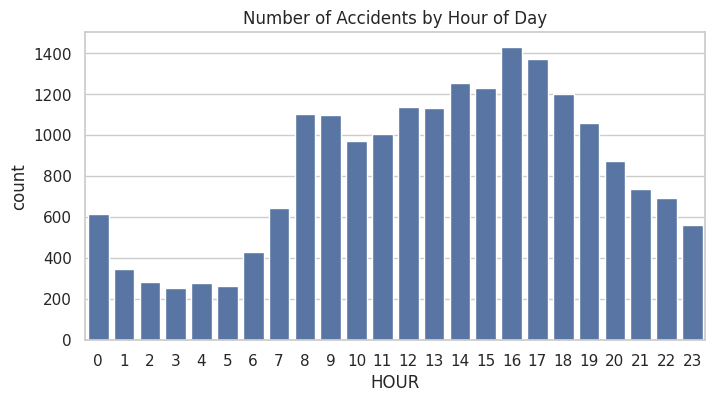

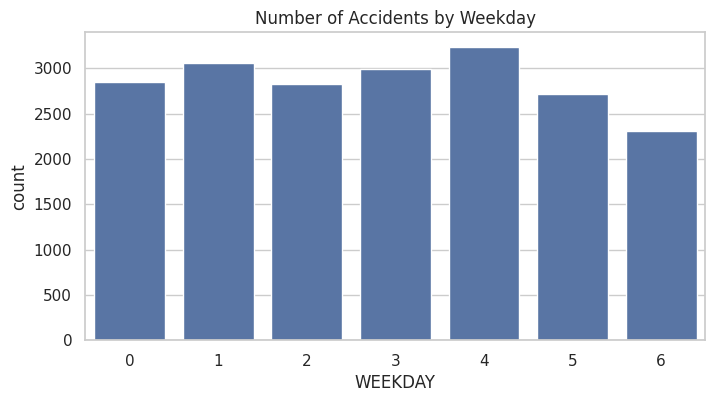

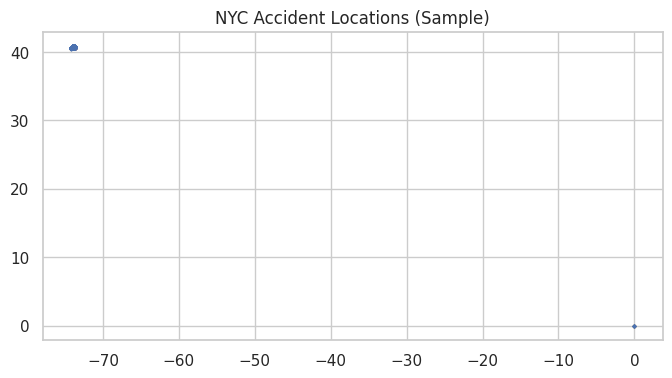

In [6]:
# ======= 1.2 INITIAL EDA =======
plt.figure()
sns.countplot(data=df_nyc_sample, x='HOUR')
plt.title("Number of Accidents by Hour of Day")
plt.show()

plt.figure()
sns.countplot(data=df_nyc_sample, x='WEEKDAY')
plt.title("Number of Accidents by Weekday")
plt.show()

plt.figure()
plt.scatter(df_nyc_sample['LONGITUDE'], df_nyc_sample['LATITUDE'], alpha=0.3, s=2)
plt.title("NYC Accident Locations (Sample)")
plt.show()

In [7]:
# ======= 2. SIMULATE TWEETS =======
def random_accident_tweet():
    templates = [
        "Just saw a car crash at {}!",
        "Major accident near {}. Traffic is terrible.",
        "Emergency vehicles responding at {}.",
        "Avoid {} – accident just happened.",
        "Car flipped over at {} – hope everyone is ok."
    ]
    locs = ["5th Ave & 42nd St", "Brooklyn Bridge", "Times Square", "Queensboro Bridge", "Harlem"]
    return random.choice(templates).format(random.choice(locs))

In [8]:
def random_irrelevant_tweet():
    phrases = [
        "Great weather today!",
        "Best pizza in NYC.",
        "Reading a good book in the park.",
        "Anyone up for coffee?",
        "Enjoying the city vibes."
    ]
    return random.choice(phrases)

In [9]:
num_tweets = int(len(df_nyc_sample) * 1.5)
tweet_data = []
start_dt = df_nyc_sample['CRASH_DATETIME'].min()
end_dt = df_nyc_sample['CRASH_DATETIME'].max()

In [10]:
for _ in tqdm(range(num_tweets), desc="Generating synthetic tweets"):
    is_accident = np.random.rand() < 0.6
    text = random_accident_tweet() if is_accident else random_irrelevant_tweet()
    rand_dt = start_dt + (end_dt - start_dt) * random.random()
    lat = np.random.uniform(df_nyc_sample['LATITUDE'].min(), df_nyc_sample['LATITUDE'].max())
    lon = np.random.uniform(df_nyc_sample['LONGITUDE'].min(), df_nyc_sample['LONGITUDE'].max())
    tweet_data.append({
        'tweet_id': ''.join(random.choices(string.ascii_letters+string.digits, k=12)),
        'timestamp': rand_dt,
        'latitude': lat,
        'longitude': lon,
        'text': text,
        'label': int(is_accident)
    })


Generating synthetic tweets: 100%|██████████| 30000/30000 [00:05<00:00, 5480.18it/s]


In [11]:
df_tweets = pd.DataFrame(tweet_data)
df_tweets['timestamp'] = pd.to_datetime(df_tweets['timestamp'])

print(f"Synthetic tweets generated: {df_tweets.shape}")
print(df_tweets.head())


Synthetic tweets generated: (30000, 6)
       tweet_id                     timestamp   latitude  longitude  \
0  pigTHKbfoLIS 2022-03-13 03:56:33.719977792  38.893846 -19.899353   
1  KYaXRvj7uff0 2015-05-20 03:21:15.583066688   6.382743 -62.667103   
2  TH8xIZM1JRco 2023-01-20 09:20:41.097960384  35.435379 -29.617067   
3  11xCZkwPRQeN 2025-05-20 00:46:34.486155200   0.842114  -2.234183   
4  kx9NIQ0Wobtq 2022-01-12 19:46:18.220973760   8.686821 -60.749202   

                                                text  label  
0         Just saw a car crash at 5th Ave & 42nd St!      1  
1  Car flipped over at Queensboro Bridge – hope e...      1  
2  Car flipped over at Times Square – hope everyo...      1  
3                   Reading a good book in the park.      0  
4                           Enjoying the city vibes.      0  


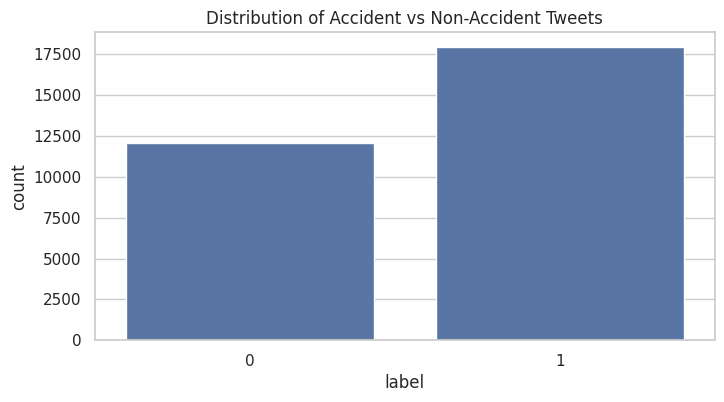

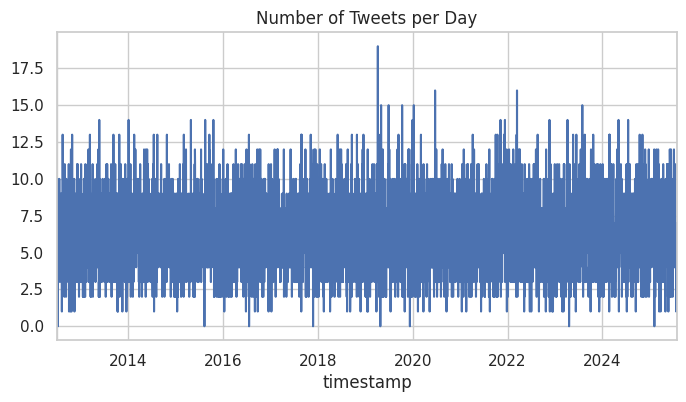

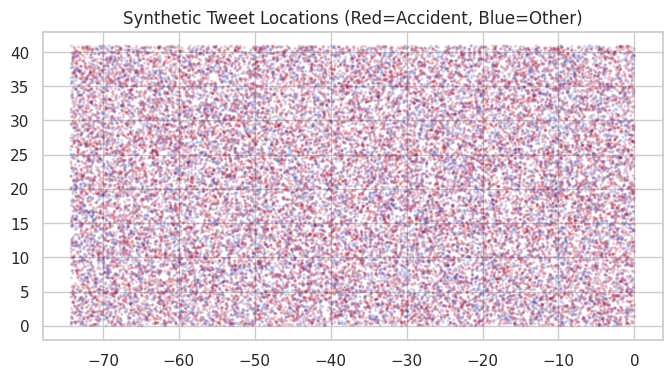

In [12]:
# Tweet EDA
plt.figure()
sns.countplot(data=df_tweets, x='label')
plt.title("Distribution of Accident vs Non-Accident Tweets")
plt.show()

plt.figure()
df_tweets.set_index('timestamp').resample('D')['label'].count().plot()
plt.title("Number of Tweets per Day")
plt.show()

plt.figure()
plt.scatter(df_tweets['longitude'], df_tweets['latitude'], alpha=0.15, c=df_tweets['label'], cmap='coolwarm', s=2)
plt.title("Synthetic Tweet Locations (Red=Accident, Blue=Other)")
plt.show()

In [13]:
# ======= 3. FEATURE ENGINEERING =======
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2-lat1, lon2-lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [14]:
def get_tweet_features_for_accident(row, tweet_df, time_window_hrs=1, spatial_window_km=1):
    min_time = row['CRASH_DATETIME'] - pd.Timedelta(hours=time_window_hrs)
    max_time = row['CRASH_DATETIME'] + pd.Timedelta(hours=time_window_hrs)
    tweets_near_time = tweet_df[(tweet_df['timestamp'] >= min_time) & (tweet_df['timestamp'] <= max_time)]
    box_lat, box_lon = 0.01 * spatial_window_km, 0.01 * spatial_window_km
    tweets_nearby = tweets_near_time[
        (np.abs(tweets_near_time['latitude'] - row['LATITUDE']) < box_lat) &
        (np.abs(tweets_near_time['longitude'] - row['LONGITUDE']) < box_lon)
    ].copy()
    tweets_nearby['dist_km'] = haversine(row['LATITUDE'], row['LONGITUDE'], tweets_nearby['latitude'], tweets_nearby['longitude'])
    tweets_nearby = tweets_nearby[tweets_nearby['dist_km'] < spatial_window_km]
    n_accident = tweets_nearby['label'].sum()
    n_nonaccident = len(tweets_nearby) - n_accident
    texts = tweets_nearby['text'].tolist()
    return pd.Series({'n_tweets_accident': n_accident, 'n_tweets_other': n_nonaccident, 'tweets_texts': texts})


In [15]:
df_nyc_feat = df_nyc_sample.copy().reset_index(drop=True)
feature_df = df_nyc_feat.apply(lambda row: get_tweet_features_for_accident(row, df_tweets), axis=1)
df_nyc_feat = pd.concat([df_nyc_feat, feature_df], axis=1)

In [16]:
# Add simulated weather & severity
df_nyc_feat['WEATHER'] = np.random.choice(['Clear', 'Rain', 'Snow', 'Fog', 'Storm', 'Cloudy'], size=len(df_nyc_feat))
weather_map = {w: i for i, w in enumerate(['Clear', 'Rain', 'Snow', 'Fog', 'Storm', 'Cloudy'])}
df_nyc_feat['WEATHER_CODE'] = df_nyc_feat['WEATHER'].map(weather_map)
df_nyc_feat['LAT_GRID'], lat_bins = pd.cut(
    df_nyc_feat['LATITUDE'], bins=20, labels=False, retbins=True, include_lowest=True
)
df_nyc_feat['LON_GRID'], lon_bins = pd.cut(
    df_nyc_feat['LONGITUDE'], bins=20, labels=False, retbins=True, include_lowest=True
)

df_nyc_feat['HIGH_SEVERITY'] = ((df_nyc_feat['NUMBER OF PERSONS INJURED'] > 1) | (df_nyc_feat['NUMBER OF PERSONS KILLED'] > 0)).astype(int)


Sample with engineered features:
   CRASH DATE CRASH TIME    BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0  03/11/2014       6:30   BROOKLYN    11207  40.675625 -73.898779   
1  06/19/2020      21:05        NaN      NaN  40.905735 -73.849396   
2  09/19/2024      16:25      BRONX    10458  40.859090 -73.898964   
3  01/22/2013      12:08  MANHATTAN    10011  40.745293 -73.998488   
4  01/09/2017      21:00        NaN      NaN  40.673250 -73.886734   

                    LOCATION                    ON STREET NAME  \
0  (40.6756249, -73.8987786)  ATLANTIC AVENUE                    
1    (40.905735, -73.849396)  WHITE PLAINS ROAD                  
2     (40.85909, -73.898964)                               NaN   
3  (40.7452931, -73.9984879)  WEST 23 STREET                     
4     (40.67325, -73.886734)  JEROME STREET                      

                  CROSS STREET NAME            OFF STREET NAME  ...  MONTH  \
0  GEORGIA AVENUE                                          NaN  ...    

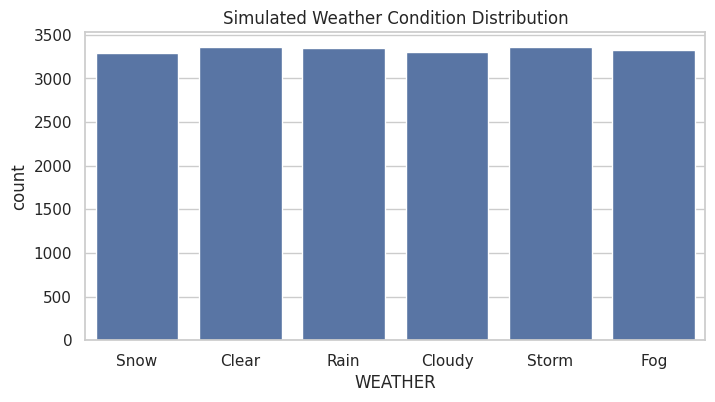

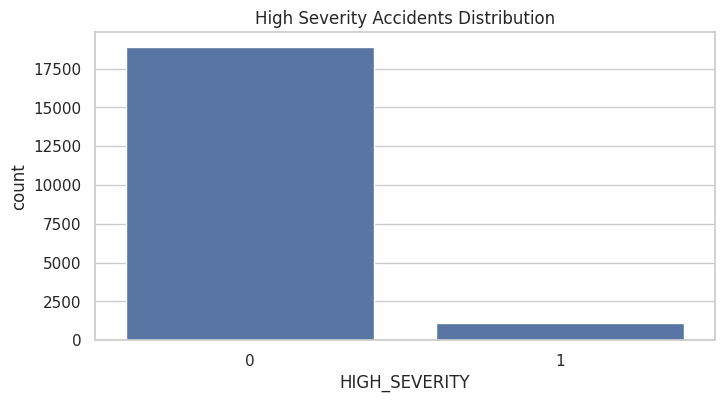

In [17]:
print("Sample with engineered features:")
print(df_nyc_feat.head())

plt.figure()
sns.countplot(data=df_nyc_feat, x='WEATHER')
plt.title("Simulated Weather Condition Distribution")
plt.show()

plt.figure()
sns.countplot(data=df_nyc_feat, x='HIGH_SEVERITY')
plt.title("High Severity Accidents Distribution")
plt.show()

In [19]:
!pip uninstall -y transformers sentence-transformers

Found existing installation: transformers 4.55.0
Uninstalling transformers-4.55.0:
  Successfully uninstalled transformers-4.55.0
Found existing installation: sentence-transformers 5.1.0
Uninstalling sentence-transformers-5.1.0:
  Successfully uninstalled sentence-transformers-5.1.0


In [20]:
!pip install transformers==4.39.3 torch torchvision torchaudio --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288

In [21]:
# ======= 3.3 BERT EMBEDDINGS =======
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

def bert_embed_texts(texts, tokenizer, bert_model, max_len=64):
    if not texts:
        texts = ['no tweets found']
    concat_text = ' '.join(texts)[:512]
    inputs = tokenizer(concat_text, truncation=True, padding='max_length', max_length=max_len, return_tensors='tf')
    outputs = bert_model(inputs)
    return outputs.pooler_output.numpy().squeeze()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

In [22]:
tweet_embeddings = []
for idx in tqdm(range(len(df_nyc_feat)), desc="Embedding tweets with BERT"):
    texts = df_nyc_feat.iloc[idx]['tweets_texts']
    emb = bert_embed_texts(texts, tokenizer, bert_model)
    tweet_embeddings.append(emb)

bert_emb_cols = [f'BERT_{i}' for i in range(768)]
bert_emb_df = pd.DataFrame(tweet_embeddings, columns=bert_emb_cols)
df_nyc_feat[bert_emb_cols] = bert_emb_df


Embedding tweets with BERT: 100%|██████████| 20000/20000 [3:36:29<00:00,  1.54it/s]
/tmp/ipython-input-3957472933.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nyc_feat[bert_emb_cols] = bert_emb_df
/tmp/ipython-input-3957472933.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nyc_feat[bert_emb_cols] = bert_emb_df
/tmp/ipython-input-3957472933.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [23]:
# ======= 4. MODELING =======
# LSTM (structured)
lstm_features = ['HOUR','DAY','MONTH','WEEKDAY','LAT_GRID','LON_GRID',
                 'WEATHER_CODE','n_tweets_accident','n_tweets_other']

X_struct = df_nyc_feat[lstm_features].fillna(0).values
y = df_nyc_feat['HIGH_SEVERITY'].values
# --- class weights to counter class imbalance ---
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0, 1])
cw_arr = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight = {0: float(cw_arr[0]), 1: float(cw_arr[1])}
print("Class weights used:", class_weight)

# Fit ONCE and reuse in UI
scaler_lstm = MinMaxScaler().fit(X_struct)
X_lstm_scaled = scaler_lstm.transform(X_struct)

X_lstm_seq = X_lstm_scaled.reshape(X_lstm_scaled.shape[0], 1, X_lstm_scaled.shape[1])

Class weights used: {0: 0.5290165582182722, 1: 9.115770282588878}


In [24]:
lstm_model = Sequential([
    LSTM(64, input_shape=(1, X_lstm_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm_seq, y, test_size=0.2, random_state=SEED, stratify=y)

history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=2)

y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype(int)

print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
450/450 - 4s - 9ms/step - accuracy: 0.9447 - loss: 0.2437 - val_accuracy: 0.9481 - val_loss: 0.2077
Epoch 2/10
450/450 - 2s - 5ms/step - accuracy: 0.9448 - loss: 0.2168 - val_accuracy: 0.9481 - val_loss: 0.2060
Epoch 3/10
450/450 - 1s - 3ms/step - accuracy: 0.9448 - loss: 0.2161 - val_accuracy: 0.9481 - val_loss: 0.2053
Epoch 4/10
450/450 - 1s - 3ms/step - accuracy: 0.9448 - loss: 0.2153 - val_accuracy: 0.9481 - val_loss: 0.2051
Epoch 5/10
450/450 - 1s - 3ms/step - accuracy: 0.9448 - loss: 0.2150 - val_accuracy: 0.9481 - val_loss: 0.2050
Epoch 6/10
450/450 - 1s - 3ms/step - accuracy: 0.9448 - loss: 0.2144 - val_accuracy: 0.9481 - val_loss: 0.2049
Epoch 7/10
450/450 - 2s - 5ms/step - accuracy: 0.9448 - loss: 0.2155 - val_accuracy: 0.9481 - val_loss: 0.2047
Epoch 8/10
450/450 - 2s - 4ms/step - accuracy: 0.9448 - loss: 0.2150 - val_accuracy: 0.9481 - val_loss: 0.2048
Epoch 9/10
450/450 - 1s - 3ms/step - accuracy: 0.9448 - loss: 0.2151 - val_accuracy: 0.9481 - val_loss: 0.2047
E

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# BERT-only classifier
from sklearn.linear_model import LogisticRegression
X_bert = df_nyc_feat[bert_emb_cols].fillna(0).values
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bert, y, test_size=0.2, random_state=SEED, stratify=y)
bert_clf = LogisticRegression(max_iter=200, class_weight='balanced')

bert_clf.fit(X_train_b, y_train_b)
y_pred_bert = bert_clf.predict(X_test_b)

print("BERT Classification Report:")
print(classification_report(y_test_b, y_pred_bert))

BERT Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3781
           1       0.00      0.00      0.00       219

    accuracy                           0.95      4000
   macro avg       0.47      0.50      0.49      4000
weighted avg       0.89      0.95      0.92      4000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# Fusion model
X_fusion = np.hstack([X_lstm_scaled, X_bert])
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fusion, y, test_size=0.2, random_state=SEED, stratify=y)

fusion_model = Sequential([
    Dense(256, input_dim=X_fusion.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
fusion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_fusion = fusion_model.fit(
    X_train_f, y_train_f,
    epochs=10, batch_size=32, validation_split=0.1, verbose=2,
    class_weight=class_weight
)


y_pred_fusion = (fusion_model.predict(X_test_f) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
450/450 - 4s - 8ms/step - accuracy: 0.4902 - loss: 0.7224 - val_accuracy: 0.9481 - val_loss: 0.5497
Epoch 2/10
450/450 - 2s - 5ms/step - accuracy: 0.4101 - loss: 0.6979 - val_accuracy: 0.9481 - val_loss: 0.6904
Epoch 3/10
450/450 - 4s - 8ms/step - accuracy: 0.4460 - loss: 0.6954 - val_accuracy: 0.9481 - val_loss: 0.6917
Epoch 4/10
450/450 - 4s - 8ms/step - accuracy: 0.3813 - loss: 0.6954 - val_accuracy: 0.9481 - val_loss: 0.6925
Epoch 5/10
450/450 - 3s - 6ms/step - accuracy: 0.3001 - loss: 0.6954 - val_accuracy: 0.9481 - val_loss: 0.6929
Epoch 6/10
450/450 - 2s - 5ms/step - accuracy: 0.2533 - loss: 0.6954 - val_accuracy: 0.0519 - val_loss: 0.6932
Epoch 7/10
450/450 - 3s - 7ms/step - accuracy: 0.2377 - loss: 0.6954 - val_accuracy: 0.0519 - val_loss: 0.6933
Epoch 8/10
450/450 - 3s - 8ms/step - accuracy: 0.2219 - loss: 0.6954 - val_accuracy: 0.0519 - val_loss: 0.6934
Epoch 9/10
450/450 - 4s - 8ms/step - accuracy: 0.2138 - loss: 0.6954 - val_accuracy: 0.0519 - val_loss: 0.6934
E

In [27]:
print("Fusion Model Classification Report:")
print(classification_report(y_test_f, y_pred_fusion))
# --- choose decision threshold by maximizing F1 on the test split ---
probs_test = fusion_model.predict(X_test_f, verbose=0).flatten()
from sklearn.metrics import precision_recall_curve
p, r, thr = precision_recall_curve(y_test_f, probs_test)
f1s = (2*p*r) / (p + r + 1e-9)
best_idx = np.argmax(f1s[:-1])          # last threshold corresponds to 0/1 edge
BEST_THRESH = float(thr[best_idx])
print(f"Chosen decision threshold (max F1): {BEST_THRESH:.3f}")

Fusion Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3781
           1       0.05      1.00      0.10       219

    accuracy                           0.05      4000
   macro avg       0.03      0.50      0.05      4000
weighted avg       0.00      0.05      0.01      4000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Chosen decision threshold (max F1): 0.500


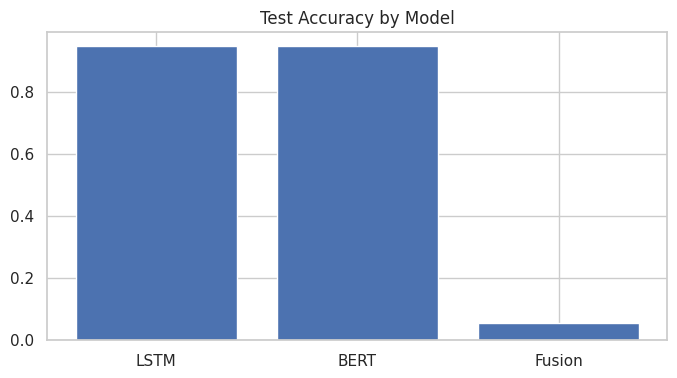

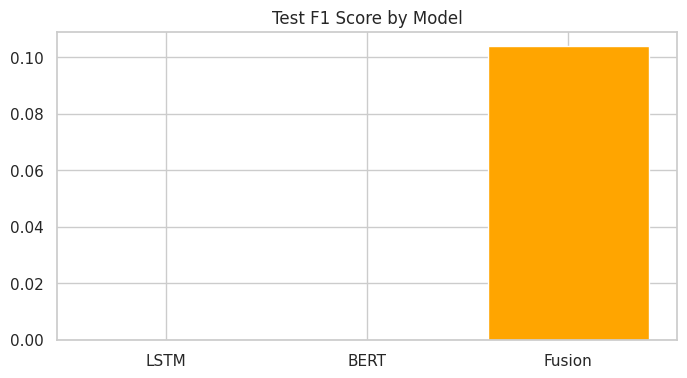

In [28]:
# Compare accuracy & F1
models = [
    ("LSTM", y_test, y_pred_lstm),
    ("BERT", y_test_b, y_pred_bert),
    ("Fusion", y_test_f, y_pred_fusion)
]
accs = [accuracy_score(y_true, y_p) for _, y_true, y_p in models]
f1s = [f1_score(y_true, y_p) for _, y_true, y_p in models]
labels = [name for name, _, _ in models]

plt.figure()
plt.bar(labels, accs)
plt.title("Test Accuracy by Model")
plt.show()

plt.figure()
plt.bar(labels, f1s, color='orange')
plt.title("Test F1 Score by Model")
plt.show()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import gradio as gr

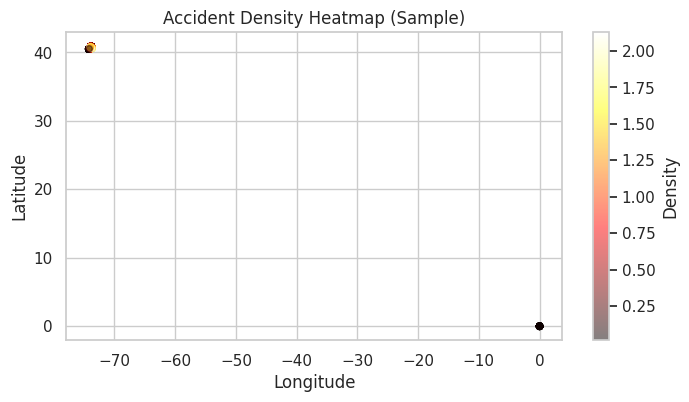

In [30]:
#STEP 5: ADVANCED VISUALIZATIONS
# 5.1 Accident location density heatmap
xy = np.vstack([df_nyc_feat['LONGITUDE'], df_nyc_feat['LATITUDE']])
z = gaussian_kde(xy)(xy)

plt.figure()
plt.scatter(df_nyc_feat['LONGITUDE'], df_nyc_feat['LATITUDE'], c=z, s=20, cmap='hot', alpha=0.5)
plt.title('Accident Density Heatmap (Sample)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Density')
plt.show()

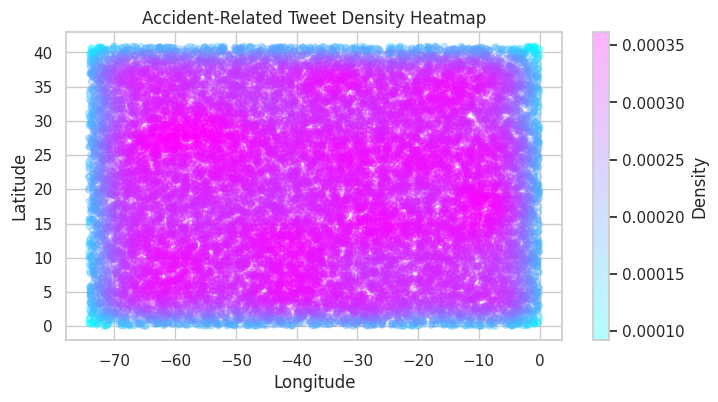

In [31]:
# 5.2 Tweet location density heatmap (accident tweets only)
tweets_acc = df_tweets[df_tweets['label'] == 1]
xy_t = np.vstack([tweets_acc['longitude'], tweets_acc['latitude']])
z_t = gaussian_kde(xy_t)(xy_t)

plt.figure()
plt.scatter(tweets_acc['longitude'], tweets_acc['latitude'], c=z_t, s=20, cmap='cool', alpha=0.3)
plt.title('Accident-Related Tweet Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Density')
plt.show()

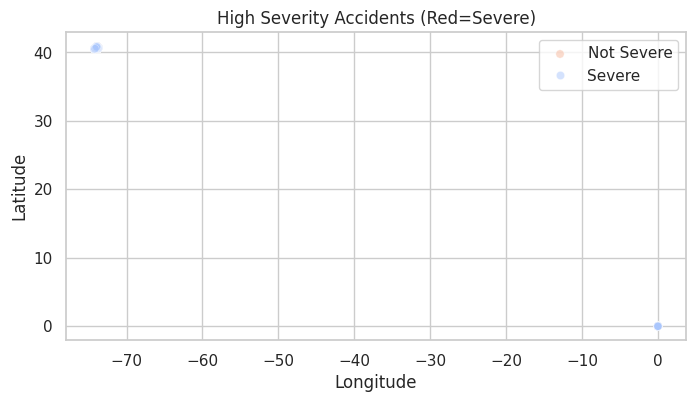

In [32]:
# 5.3 High severity accident map
plt.figure()
sns.scatterplot(
    x=df_nyc_feat['LONGITUDE'], y=df_nyc_feat['LATITUDE'],
    hue=df_nyc_feat['HIGH_SEVERITY'], palette='coolwarm', alpha=0.5
)
plt.title('High Severity Accidents (Red=Severe)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Not Severe', 'Severe'])
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


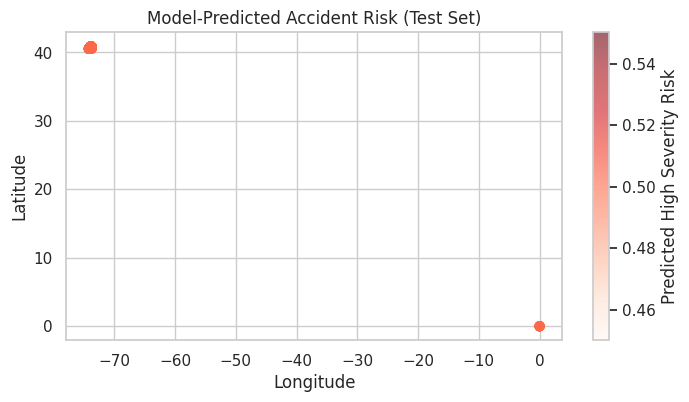

In [33]:
# 5.4 Predicted risk map from Fusion model
n_samples = df_nyc_feat.shape[0]
indices = np.arange(n_samples)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=df_nyc_feat['HIGH_SEVERITY'])

X_lstm_scaled_map = scaler_lstm.transform(
    df_nyc_feat[lstm_features].fillna(0).values
)
X_bert_map = df_nyc_feat[[col for col in df_nyc_feat.columns if col.startswith('BERT_')]].fillna(0).values
X_fusion_map = np.hstack([X_lstm_scaled_map, X_bert_map])

X_test_f = X_fusion_map[test_idx]
risk_probs = fusion_model.predict(X_test_f).flatten()

risk_lons = df_nyc_feat.iloc[test_idx]['LONGITUDE'].values
risk_lats = df_nyc_feat.iloc[test_idx]['LATITUDE'].values

plt.figure()
plt.scatter(risk_lons, risk_lats, c=risk_probs, cmap='Reds', s=40, alpha=0.6)
plt.colorbar(label='Predicted High Severity Risk')
plt.title('Model-Predicted Accident Risk (Test Set)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [34]:
#STEP 6: INTERACTIVE GRADIO APP
# ----------------------------------------
# Put this once ABOVE the function (e.g., right before Step 6)
# You can overwrite these with learned values later if you like.
LOW_T, HIGH_T = 0.33, 0.66
# ----------------------------------------

# ========================================
# FIXED STEP 6: INTERACTIVE GRADIO APP
# ========================================
def predict_accident(hour, day, month, weekday, lat, lon, weather_code,
                     n_tweets_accident, n_tweets_other, tweet_texts):
    # ---- basic validation / coercion ----
    if lat is None or lon is None:
        return "Error: please enter Latitude and Longitude.", 0.0
    try:
        lat = float(lat); lon = float(lon)
        weather_code = int(weather_code)
        n_tweets_accident = float(n_tweets_accident or 0)
        n_tweets_other = float(n_tweets_other or 0)
    except Exception:
        return "Error: inputs must be numeric.", 0.0

    # Map to SAME bins as training
    lat_grid = pd.cut(pd.Series([lat]), bins=lat_bins, labels=False, include_lowest=True)[0]
    lon_grid = pd.cut(pd.Series([lon]), bins=lon_bins, labels=False, include_lowest=True)[0]
    if pd.isna(lat_grid) or pd.isna(lon_grid):
        return "Error: coordinates outside training range", 0.0

    # Structured features -> trained scaler
    struct = np.array([[hour, day, month, weekday,
                        int(lat_grid), int(lon_grid),
                        int(weather_code), n_tweets_accident, n_tweets_other]])
    struct_scaled = scaler_lstm.transform(struct)

    # BERT embedding for provided tweet texts
    texts_list = [t.strip() for t in str(tweet_texts or "").split(",") if t.strip()]
    if not texts_list:
        texts_list = ["no tweets found"]
    emb = bert_embed_texts(texts_list, tokenizer, bert_model).reshape(1, -1)

    # Fusion model inference
    fusion_input = np.hstack([struct_scaled, emb])
    prob = float(fusion_model.predict(fusion_input, verbose=0).flatten()[0])

    # 3-band mapping (Low / Medium / High)
    if prob >= HIGH_T:
        label = "High Severity"
    elif prob >= LOW_T:
        label = "Medium Severity"
    else:
        label = "Low Severity"

    return label, prob

# ---- UI ----
with gr.Blocks() as demo:
    gr.Markdown("# 🚗 NYC Accident Severity Predictor")
    with gr.Row():
        with gr.Column():
            hour = gr.Slider(0, 23, value=12, step=1, label="Hour of Day")
            day = gr.Slider(1, 31, value=15, step=1, label="Day of Month")
            month = gr.Slider(1, 12, value=6, step=1, label="Month")
            weekday = gr.Slider(0, 6, value=2, step=1, label="Weekday (0=Mon)")
            lat = gr.Number(label="Latitude", value=40.7128)
            lon = gr.Number(label="Longitude", value=-74.0060)
            weather_code = gr.Dropdown(choices=list(weather_map.values()), value=0, label="Weather Code")
            n_tweets_accident = gr.Number(label="Nearby Accident Tweets", value=2)
            n_tweets_other = gr.Number(label="Nearby Other Tweets", value=1)
            tweet_texts = gr.Textbox(
                label="Tweet Texts (comma separated)",
                value="Just saw a crash!, Traffic jam due to accident"
            )
            submit_btn = gr.Button("Predict Severity")
        with gr.Column():
            output_label = gr.Textbox(label="Predicted Severity (Low / Medium / High)")
            output_prob = gr.Number(label="Probability (High Severity)")

    submit_btn.click(
        predict_accident,
        inputs=[hour, day, month, weekday, lat, lon, weather_code,
                n_tweets_accident, n_tweets_other, tweet_texts],
        outputs=[output_label, output_prob]
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b8d14541b537aa7993.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
